### SECTION 1: Data Loading & Preprocessing

In [40]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("https://www.football-data.co.uk/mmz4281/2324/E0.csv")
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A']].dropna()
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Encode match results
result_map = {'H': 0, 'D': 1, 'A': 2}
df['Result'] = df['FTR'].map(result_map)

# Compute implied probabilities
df['Imp_H'] = 1 / df['B365H']
df['Imp_D'] = 1 / df['B365D']
df['Imp_A'] = 1 / df['B365A']

total_imp = df['Imp_H'] + df['Imp_D'] + df['Imp_A']
df['Norm_H'] = df['Imp_H'] / total_imp
df['Norm_D'] = df['Imp_D'] / total_imp
df['Norm_A'] = df['Imp_A'] / total_imp

# Odds Ratios
df['H_A_ratio'] = df['B365H'] / df['B365A']
df['D_A_ratio'] = df['B365D'] / df['B365A']
df['H_D_ratio'] = df['B365H'] / df['B365D']
df['Odds_Spread'] = df[['B365H', 'B365D', 'B365A']].max(axis=1) - df[['B365H', 'B365D', 'B365A']].min(axis=1)

# Sort and split
df = df.sort_values('Date').reset_index(drop=True)
split_date = df['Date'].quantile(0.75)
df_train = df[df['Date'] <= split_date].copy()
df_test = df[df['Date'] > split_date].copy()

### SECTION 2: Feature Engineering (Win Rates Only)

In [41]:
# Rolling win rates only (leak-free)
def compute_team_stats(df):
    df['HomeWin'] = (df['Result'] == 0).astype(int)
    df['AwayWin'] = (df['Result'] == 2).astype(int)

    df['HomeTeamWinRate'] = df.groupby('HomeTeam')['HomeWin'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    df['AwayTeamWinRate'] = df.groupby('AwayTeam')['AwayWin'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())

    return df

# Apply to full dataset
df = compute_team_stats(df)

### SECTION 3: Recent Form Features

In [42]:
# Helper to compute recent form (number of wins in last 5 matches)
def compute_recent_form(df, team_col, result_col, target_value):
    recent_form = []
    for i in range(len(df)):
        team = df.iloc[i][team_col]
        match_date = df.iloc[i]['Date']
        past_matches = df[(df[team_col] == team) & (df['Date'] < match_date)]
        recent_results = past_matches[result_col].tail(5)
        recent_wins = (recent_results == target_value).sum()
        recent_form.append(recent_wins / 5)
    return recent_form

# Apply to compute form
print("\n⏳ Calculating recent form features...")
df['HomeRecentForm'] = compute_recent_form(df, 'HomeTeam', 'Result', 0)
df['AwayRecentForm'] = compute_recent_form(df, 'AwayTeam', 'Result', 2)
df['RecentForm'] = df['HomeRecentForm'] - df['AwayRecentForm']


⏳ Calculating recent form features...


### SECTION 3B: Re-split After Feature Engineering

In [43]:
# Re-split after adding engineered features
split_date = df['Date'].quantile(0.75)
df_train = df[df['Date'] <= split_date].copy()
df_test = df[df['Date'] > split_date].copy()

### SECTION 4: Logistic Regression Model

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

features = [
    'Norm_H', 'Norm_D', 'Norm_A', 'H_A_ratio', 'D_A_ratio', 'H_D_ratio',
    'Odds_Spread', 'HomeTeamWinRate', 'AwayTeamWinRate',
    'RecentForm', 'HomeRecentForm', 'AwayRecentForm'
]

X_train = df_train[features]
y_train = df_train['Result']
X_test = df_test[features]
y_test = df_test['Result']

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
preds_lr = model_lr.predict(X_test)

### SECTION 5: Random Forest Model

In [45]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_test)

### SECTION 6: XGBoost Model

In [51]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)

### SECTION 7: EV & Confidence-Based Betting Simulation

In [52]:
from sklearn.calibration import CalibratedClassifierCV

models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "XGBoost": model_xgb
}

model_stats = {}

for name, base_model in models.items():
    model = CalibratedClassifierCV(base_model, cv=3)
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    preds = np.argmax(probs, axis=1)

    confident_bets = 0
    total_profit = 0
    ev_threshold = 0.05
    confidence_threshold = 0.5

    for i in range(len(probs)):
        evs = []
        for j in range(3):
            prob = probs[i][j]
            odd = df_test.iloc[i][['B365H', 'B365D', 'B365A']].iloc[j]
            ev = prob * (odd - 1) - (1 - prob)
            evs.append(ev)

        best_outcome = np.argmax(evs)
        confidence = probs[i][best_outcome]

        if evs[best_outcome] >= ev_threshold and confidence >= confidence_threshold:
            confident_bets += 1
            if best_outcome == y_test.iloc[i]:
                total_profit += df_test.iloc[i][['B365H', 'B365D', 'B365A']].iloc[best_outcome] - 1
            else:
                total_profit -= 1

    acc = accuracy_score(y_test, preds)
    model_stats[name] = {
        "Accuracy": round(acc, 4),
        "Total Profit": round(total_profit, 2),
        "Bets": confident_bets
    }

### SECTION 8: Data Leakage Audit

In [53]:
print("\n🔍 Data Leakage Audit")
leakage_checks = {
    "Norm_H": "✅ Derived from pre-match odds",
    "Norm_D": "✅ Derived from pre-match odds",
    "Norm_A": "✅ Derived from pre-match odds",
    "H_A_ratio": "✅ Derived from pre-match odds",
    "D_A_ratio": "✅ Derived from pre-match odds",
    "H_D_ratio": "✅ Derived from pre-match odds",
    "Odds_Spread": "✅ Derived from pre-match odds",
    "HomeTeamWinRate": "✅ Computed from past rolling window",
    "AwayTeamWinRate": "✅ Computed from past rolling window",
    "RecentForm": "✅ Computed from past matches only",
    "HomeRecentForm": "✅ Computed from past matches only",
    "AwayRecentForm": "✅ Computed from past matches only"
}

for feature, status in leakage_checks.items():
    print(f"{feature}: {status}")

print("\n📅 Split Check")
print(f"Training Max Date: {df_train['Date'].max()}")
print(f"Testing Min Date : {df_test['Date'].min()}")
if df_train['Date'].max() < df_test['Date'].min():
    print("✅ Time-aware split confirmed. No overlap.")
else:
    print("❌ Warning: Potential time leakage due to date overlap.")


🔍 Data Leakage Audit
Norm_H: ✅ Derived from pre-match odds
Norm_D: ✅ Derived from pre-match odds
Norm_A: ✅ Derived from pre-match odds
H_A_ratio: ✅ Derived from pre-match odds
D_A_ratio: ✅ Derived from pre-match odds
H_D_ratio: ✅ Derived from pre-match odds
Odds_Spread: ✅ Derived from pre-match odds
HomeTeamWinRate: ✅ Computed from past rolling window
AwayTeamWinRate: ✅ Computed from past rolling window
RecentForm: ✅ Computed from past matches only
HomeRecentForm: ✅ Computed from past matches only
AwayRecentForm: ✅ Computed from past matches only

📅 Split Check
Training Max Date: 2024-03-30 00:00:00
Testing Min Date : 2024-03-31 00:00:00
✅ Time-aware split confirmed. No overlap.


### SECTION 9: Model Comparison Summary and Visualization


📊 Model Comparison Summary

🔹 Logistic Regression
   - Accuracy: 0.6629
   - Total Profit: -1.0
   - Confident Bets Placed: 3
   - Avg Profit per Bet (ROI): -0.33

🔹 Random Forest
   - Accuracy: 0.5618
   - Total Profit: 1.25
   - Confident Bets Placed: 12
   - Avg Profit per Bet (ROI): 0.10

🔹 XGBoost
   - Accuracy: 0.5281
   - Total Profit: -2.5
   - Confident Bets Placed: 8
   - Avg Profit per Bet (ROI): -0.31


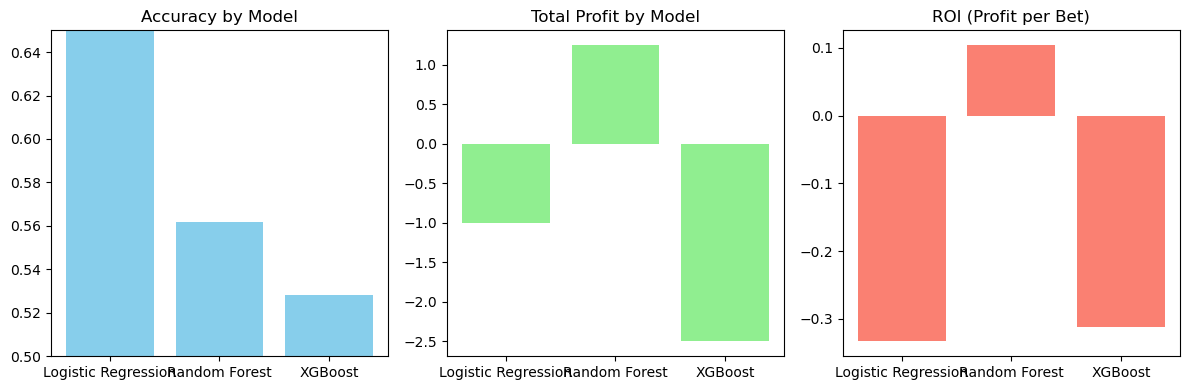

In [54]:
import matplotlib.pyplot as plt

print("\n📊 Model Comparison Summary")

for model, stats in model_stats.items():
    roi = stats["Total Profit"] / stats["Bets"] if stats["Bets"] else 0
    print(f"\n🔹 {model}")
    print(f"   - Accuracy: {stats['Accuracy']}")
    print(f"   - Total Profit: {stats['Total Profit']}")
    print(f"   - Confident Bets Placed: {stats['Bets']}")
    print(f"   - Avg Profit per Bet (ROI): {roi:.2f}")

# Visualization
models = list(model_stats.keys())
accuracies = [model_stats[m]["Accuracy"] for m in models]
profits = [model_stats[m]["Total Profit"] for m in models]
roi_values = [model_stats[m]["Total Profit"] / model_stats[m]["Bets"] if model_stats[m]["Bets"] else 0 for m in models]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(models, accuracies, color='skyblue')
plt.title("Accuracy by Model")
plt.ylim(0.5, 0.65)

plt.subplot(1, 3, 2)
plt.bar(models, profits, color='lightgreen')
plt.title("Total Profit by Model")

plt.subplot(1, 3, 3)
plt.bar(models, roi_values, color='salmon')
plt.title("ROI (Profit per Bet)")

plt.tight_layout()
plt.show()